In [1]:
import warnings
warnings.filterwarnings("ignore")

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import requests
import xgboost
from xgboost import XGBRegressor
import sklearn
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import pandas_datareader as web
from dateutil import parser
import pickle
import requests
import joblib
from datetime import datetime, timezone, date, timedelta

# Create Dataframe

In [107]:
ticker = "FB"

In [108]:
url = 'https://stock-price-predictor-af4ea-default-rtdb.firebaseio.com/'
ticker_get_url = url + ticker + '.json'

In [109]:
response = requests.get( ticker_get_url )
stock_dict = dict(response.json())

In [110]:
df_stock = pd.DataFrame({
    "Date": stock_dict['Stock Dates'],
    "Stock Close": stock_dict['Stock Close']
})

In [125]:
'trailingAnnualDividendYield' not in stock_dict['YF Info'].keys()

True

# X and Y and Train and Test for Non-NN

In [111]:
df_stock['Year'] = [x.split('-')[0] for x in list(df_stock['Date'])]
df_stock['Month'] = [x.split('-')[1] for x in list(df_stock['Date'])]
df_stock['Day'] = [x.split('-')[2] for x in list(df_stock['Date'])]

In [112]:
x = df_stock[['Year', 'Month', 'Day']].astype('int')
y = df_stock['Stock Close']

In [113]:
thresh = int(len(x)*2/3)

x_train = x[:thresh]
y_train = y[:thresh]

x_test = x[thresh:]
y_test = y[thresh:]

# NN

In [114]:
df_nn = df_stock.copy()
df_dates = df_nn[['Year', 'Month', 'Day']]
df_nn['Datetime'] = pd.to_datetime(df_dates)

In [115]:
df_close = df_nn['Stock Close']
np_close = df_close.values

In [116]:
thresh = int(np.ceil(len(np_close)*.7))

In [117]:
# scale dataset
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(np_close.reshape(-1, 1))

In [118]:
#Create the scaled training data set 
train_data = scaled_data[0:thresh]

#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [119]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [120]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [17]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [18]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [19]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1
822/822 [==============================] - 58s 70ms/step - loss: 8.2931e-04


In [20]:
test_data = scaled_data[thresh - 60: , : ]

In [21]:
x_test = []
y_test = np_close[thresh:]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [22]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [23]:
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)

In [24]:
rmse = np.sqrt(np.mean(((predictions - y_test)**2)))
rmse

30.29016354801612

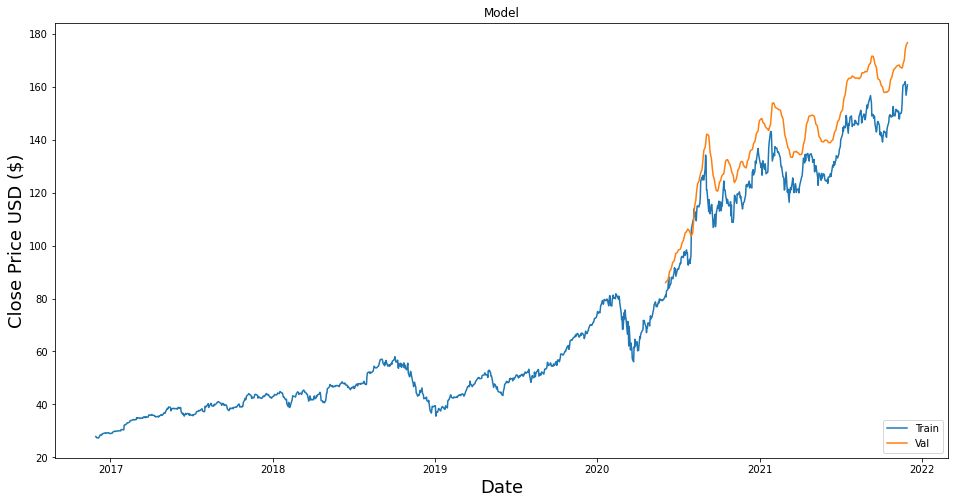

In [25]:
train = df_close[:thresh]
valid = df_close[thresh:]

valid['Predictions'] = predictions

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df_nn['Datetime'], df_nn['Stock Close'])
plt.plot(df_nn['Datetime'][thresh:], predictions)
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

## Dump Scaler and Model

In [26]:
# pickle.dump(model, open('../Models/aapl_model', 'wb'))
# joblib.dump(scaler, '../Models/aapl_scaler') 

In [65]:
# loaded_model = pickle.load(open('../Models/aapl_model', 'rb'))
# scaler = joblib.load('../Models/aapl_scaler')

## Forecast 7 Days Ahead

In [65]:
running_60_days = list(scaled_data[len(df_stock)-60:].reshape(-1))

In [72]:
for i in range(0, 7):
    running_np = np.array(running_60_days).reshape(1,-1,1)
    next_day = model.predict(running_np)[0][0]
    running_60_days.pop(0)
    running_60_days.append(next_day)

In [77]:
next_seven_days = scaler.inverse_transform(np.array(running_60_days[len(running_60_days)-7:]).reshape(-1,1))

In [79]:
next_seven_days = list(next_seven_days.reshape(-1))

In [81]:
next_seven_days

[180.05377, 183.48718, 187.53987, 192.00955, 196.76984, 201.7412, 206.87213]

# XGBoost

In [162]:
# model_xgboost = XGBRegressor()
# model_xgboost.fit(x_train, y_train)

# pred_results = list(model.predict(x_test))

# datetime_dates = [datetime(int(x.split('-')[0]), int(x.split('-')[1]), int(x.split('-')[2])) 
#                   for x in list(df_stock['Date'])]

# plt.plot(datetime_dates, y)
# plt.plot(datetime_dates[thresh:], pred_results)

# ARIMA

In [166]:
# arima_train = y_train
# arima_test = y_test

# model = auto_arima(arima_train, trace=True, error_action='ignore', suppress_warnings=True)
# model.fit(arima_train)
# forecast = model.predict(n_periods=len(arima_test))

# plt.plot(datetime_dates, y)
# plt.plot(datetime_dates[thresh:], forecast)

# Linear Regression

In [43]:
# poly_reg = PolynomialFeatures(degree=5)
# x_poly_train = poly_reg.fit_transform(x_train)
# x_poly_test = poly_reg.fit_transform(x_test)
# model_reg = LinearRegression()
# model_reg.fit(x_poly_train, y_train)

# pred_results = model_reg.predict(x_poly_test)

# plt.plot(datetime_dates, y)
# plt.plot(datetime_dates[thresh:], pred_results)

LinearRegression()

# Other Stuff to Test Code

In [41]:
ticker = "DKNG"
url = 'https://stock-price-predictor-af4ea-default-rtdb.firebaseio.com/'
ticker_get_url = url + ticker + '.json'

In [42]:
response = requests.get( ticker_get_url )
stock_dict = dict(response.json())

In [145]:
stock_dict['YF News']

[{'link': 'https://finance.yahoo.com/news/twitter-taps-cto-agrawal-revive-011634289.html',
  'providerPublishTime': 1638234994,
  'publisher': 'Bloomberg',
  'title': 'Twitter Taps CTO Agrawal to Revive Product Focus Dorsey Lacked',
  'type': 'STORY',
  'uuid': '32e76bd3-dc91-324c-9153-9fa4c7c2b4de'},
 {'link': 'https://finance.yahoo.com/m/5f695c14-bc91-363c-995e-e994c1f0807e/these-are-the-5-best-stocks.html',
  'providerPublishTime': 1638229024,
  'publisher': "Investor's Business Daily",
  'title': 'These Are The 5 Best Stocks To Buy And Watch Now',
  'type': 'STORY',
  'uuid': '5f695c14-bc91-363c-995e-e994c1f0807e'},
 {'link': 'https://finance.yahoo.com/m/e5eaed8d-72af-389b-a687-bb06160b8342/here%27s-how-metaverse.html',
  'providerPublishTime': 1638225894,
  'publisher': 'Motley Fool',
  'title': "Here's How Metaverse Shenanigans Pushed Meta Higher on Monday",
  'type': 'STORY',
  'uuid': 'e5eaed8d-72af-389b-a687-bb06160b8342'},
 {'link': 'https://finance.yahoo.com/m/ef2d813c-d4a5-

In [48]:
stock_dict.keys()

dict_keys(['Last-Update', 'Stock Close', 'Stock Dates', 'Stock Financials', 'Stock High', 'Stock Info', 'Stock Low', 'Stock Meta', 'Stock Open', 'Stock Volume', 'Ticker', 'YF Info', 'YF News'])

In [49]:
stock_dict['YF Info']['exchange']

{'52WeekChange': -0.3116883,
 'SandP52WeekChange': 0.26866078,
 'address1': '222 Berkeley Street',
 'address2': '5th Floor',
 'ask': 35.23,
 'askSize': 3000,
 'averageDailyVolume10Day': 15202100,
 'averageVolume': 13665582,
 'averageVolume10days': 15202100,
 'beta': 1.913443,
 'bid': 35.18,
 'bidSize': 1300,
 'bookValue': 4.505,
 'city': 'Boston',
 'country': 'United States',
 'currency': 'USD',
 'currentPrice': 35.2,
 'currentRatio': 3.176,
 'dateShortInterest': 1636934400,
 'dayHigh': 36.57,
 'dayLow': 34.525,
 'debtToEquity': 72.381,
 'ebitda': -1281048064,
 'ebitdaMargins': -1.11889,
 'enterpriseToEbitda': -10.597,
 'enterpriseToRevenue': 11.857,
 'enterpriseValue': 13575500800,
 'exchange': 'NMS',
 'exchangeTimezoneName': 'America/New_York',
 'exchangeTimezoneShortName': 'EST',
 'fiftyDayAverage': 46.335,
 'fiftyTwoWeekHigh': 74.38,
 'fiftyTwoWeekLow': 34.42,
 'financialCurrency': 'USD',
 'floatShares': 354020580,
 'forwardEps': -2.42,
 'forwardPE': -14.545454,
 'freeCashflow': -3

In [53]:
stock_dict['YF Info']['country']

'United States'

In [64]:
stock_dict['YF Info']['trailingPE']

KeyError: 'trailingPE'

In [50]:
stock_dict['Stock Meta']

{'chartPreviousClose': 9.8,
 'currency': 'USD',
 'currentTradingPeriod': {'post': {'end': 1638234000,
   'gmtoffset': -18000,
   'start': 1638219600,
   'timezone': 'EST'},
  'pre': {'end': 1638196200,
   'gmtoffset': -18000,
   'start': 1638176400,
   'timezone': 'EST'},
  'regular': {'end': 1638219600,
   'gmtoffset': -18000,
   'start': 1638196200,
   'timezone': 'EST'}},
 'dataGranularity': '1d',
 'exchangeName': 'NMS',
 'exchangeTimezoneName': 'America/New_York',
 'firstTradeDate': 1564061400,
 'gmtoffset': -18000,
 'instrumentType': 'EQUITY',
 'priceHint': 2,
 'range': '5y',
 'regularMarketPrice': 35.2,
 'regularMarketTime': 1638219603,
 'symbol': 'DKNG',
 'timezone': 'EST',
 'validRanges': ['1d',
  '5d',
  '1mo',
  '3mo',
  '6mo',
  '1y',
  '2y',
  '5y',
  'ytd',
  'max']}

In [87]:
split_today = '2021-12-29'.split('-')
split_today = [int(x) for x in split_today]

In [90]:
datetime_today = datetime(split_today[0], split_today[1], split_today[2])

In [103]:
seven_dates = []
datetime_today = datetime.now() + timedelta(days=1)
count = 0
while(count < 7):
    if datetime_today.weekday() not in [5, 6]:
        date_str = (str(datetime_today.year) + '-' + 
                    str(datetime_today.month) + '-' + str(datetime_today.day))
        seven_dates.append(date_str)
        count = count + 1
    datetime_today = datetime_today + timedelta(days=1)

In [106]:
seven_dates[0]

'2021-11-30'